In [1]:
import pandas as pd
import numpy as np
import os.path
import copy
import operator
import csv
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [2]:
# Clone git repo to be able to get the data (colab)
!git clone https://github.com/siddarth-pm/weapon-classifier.git

Cloning into 'weapon-classifier'...
remote: Enumerating objects: 1254, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1254 (delta 0), reused 13 (delta 0), pack-reused 1241
Receiving objects: 100% (1254/1254), 152.02 MiB | 54.20 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
data_csv = pd.read_csv("weapon-classifier/metadata.csv")

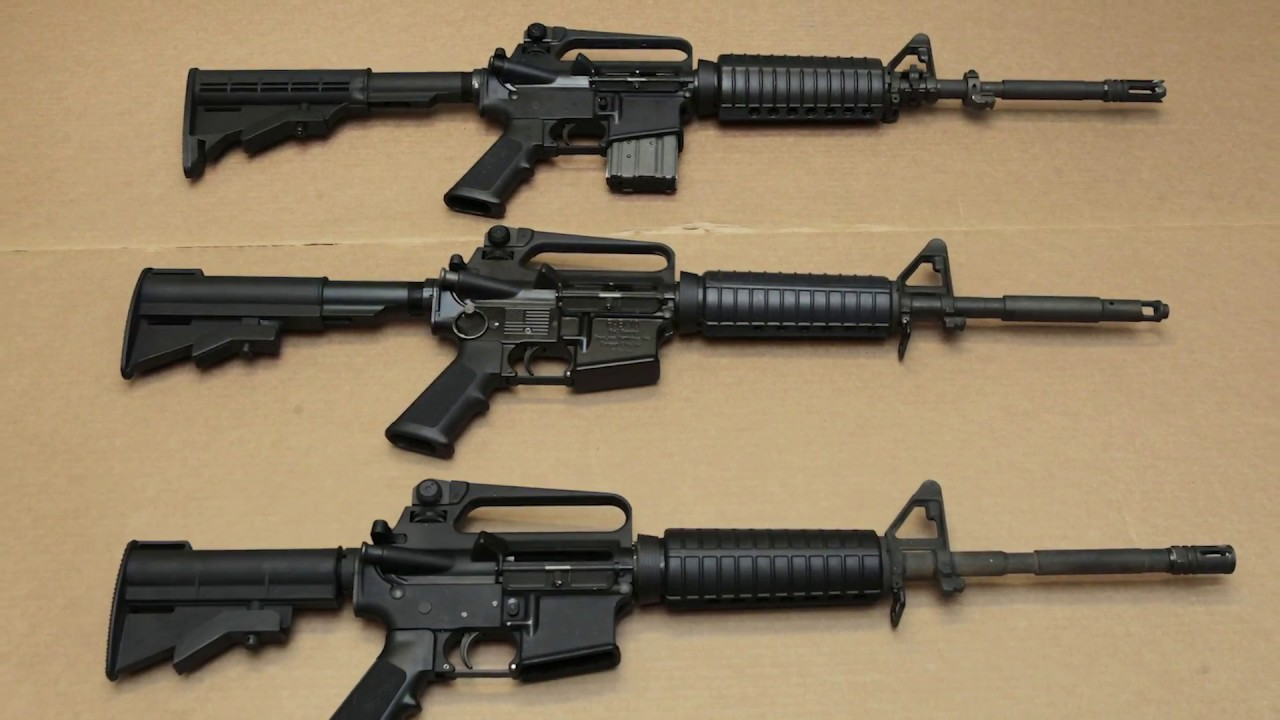

In [4]:
img = cv2.imread("/content/weapon-classifier/weapon_detection/train/images/"+data_csv.loc[0][0])
cv2_imshow(img) # Show first image

In [27]:
img = cv2.imread("/content/weapon-classifier/weapon_detection/train/images/"+data_csv.loc[(a, "imagefile")])
print(img.shape)

(720, 1280, 3)
23


In [44]:
imgs = []
labels = []
with open("/content/weapon-classifier/metadata.csv") as f:
    reader = csv.reader(f)
    c = 0
    for row in reader:
      if c==0:
        c+=1
        continue
      if (os.path.isfile("/content/weapon-classifier/weapon_detection/train/images/"+row[0])):
        img = cv2.imread("/content/weapon-classifier/weapon_detection/train/images/"+row[0])
        # Only allowing data with max size (1500, 1500)--over half of
        # the data fulfills this and the data with size less than 
        # (1500, 1500) will be padded
        if(img.shape[0] <= 1500 and img.shape[1] <= 1500):
          imgs.append(img)
          labels.append(row[2])
      c+=1

In [45]:
padded_imgs = []
for img in imgs:
  h = img.shape[0]
  w = img.shape[1]
  # Pad all images so that each image is (1500, 1500, 3)
  padded_imgs.append(cv2.copyMakeBorder(img, int((1500 - h)/2), int((1500-h)/2) + (h%2 != 0),
                                 int((1500-w)/2), int((1500-w)/2) + (w%2 != 0), cv2.BORDER_CONSTANT, value=[0,0,0]))

In [46]:
# importing ResNet50
base_model = ResNet50(input_shape=(1500, 1500, 3), weights='imagenet', include_top=False)

In [47]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation='relu')(x) # add a dense layer to train on new data
predictions = Dense(9, activation='softmax')(x) # 9 classes

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# freezing all previous resnet layers, only training the ones we just added
for layer in base_model.layers:
    layer.trainable = False

In [48]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1500, 1500,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1506, 1506,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 750, 750, 64  9472        ['conv1_pad[0][0]']              
                                )                                                           

In [50]:
# configure x and y data
x = np.array(padded_imgs)
print(x.shape)
y = np.array(labels)
y_one_hot = keras.utils.to_categorical(labels, 9)

(420, 1500, 1500, 3)


In [52]:
model.fit(x, y_one_hot, batch_size = 16, epochs=100) # Fit model with 100 epochs, low batch size for memory constraints

Epoch 1/100
27/27 [==============================] - 12s 276ms/step - loss: 5.6861 - accuracy: 0.1405
Epoch 2/100
27/27 [==============================] - 7s 257ms/step - loss: 2.7521 - accuracy: 0.2000
Epoch 3/100
27/27 [==============================] - 7s 258ms/step - loss: 2.4929 - accuracy: 0.2429
Epoch 4/100
27/27 [==============================] - 7s 258ms/step - loss: 2.1814 - accuracy: 0.3000
Epoch 5/100
27/27 [==============================] - 7s 255ms/step - loss: 2.0380 - accuracy: 0.3190
Epoch 6/100
27/27 [==============================] - 7s 255ms/step - loss: 1.9986 - accuracy: 0.3595
Epoch 7/100
27/27 [==============================] - 7s 257ms/step - loss: 1.8182 - accuracy: 0.3857
Epoch 8/100
27/27 [==============================] - 7s 259ms/step - loss: 1.7886 - accuracy: 0.4333
Epoch 9/100
27/27 [==============================] - 7s 257ms/step - loss: 1.6952 - accuracy: 0.4476
Epoch 10/100
27/27 [==============================] - 7s 255ms/step - loss: 1.4966 - accur

In [53]:
# Repeating process with validation images
val_imgs = []
val_labels = []
with open("/content/weapon-classifier/metadata.csv") as f:
    reader = csv.reader(f)
    c = 0
    for row in reader:
      if c==0:
        c+=1
        continue
      if (os.path.isfile("/content/weapon-classifier/weapon_detection/val/images/"+row[0])):
        img = cv2.imread("/content/weapon-classifier/weapon_detection/val/images/"+row[0])
        if(img.shape[0] <= 1500 and img.shape[1] <= 1500):
          val_imgs.append(img)
          val_labels.append(row[2])
      c+=1

In [54]:
# Padding validation images
padded_val_imgs = []
for img in val_imgs:
  h = img.shape[0]
  w = img.shape[1]
  padded_val_imgs.append(cv2.copyMakeBorder(img, int((1500 - h)/2), int((1500-h)/2) + (h%2 != 0),
                                 int((1500-w)/2), int((1500-w)/2) + (w%2 != 0), cv2.BORDER_CONSTANT, value=[0,0,0]))

In [55]:
# configuring validation data to make it so that we can use model.evaluate
x_val = np.array(padded_val_imgs)
y_val = np.array(val_labels)
y_val_one_hot = keras.utils.to_categorical(y_val, 9)
print(y_val_one_hot.shape)

(111, 9)


In [56]:
model.evaluate(x_val, y_val_one_hot)

4/4 [==============================] - 3s 427ms/step - loss: 1.1803 - accuracy: 0.7838


[1.180270791053772, 0.7837837934494019]

The validation error is ~80 percent, roughly 10 percent lower than our training error. Once again, a case of overfitting and adjustments to the model architecture + normalizing the data can make a difference.

In [61]:
predictions = model.predict(x_val)

4/4 [==============================] - 2s 503ms/step


In [66]:
num_to_class = {0: "AR", 1: "Bazooka", 2: "Grenade Launcher",
                3: "Handgun", 4: "Knife", 5: "Shotgun", 6: "SMG",
                7: "Sniper", 8: "Sword"}

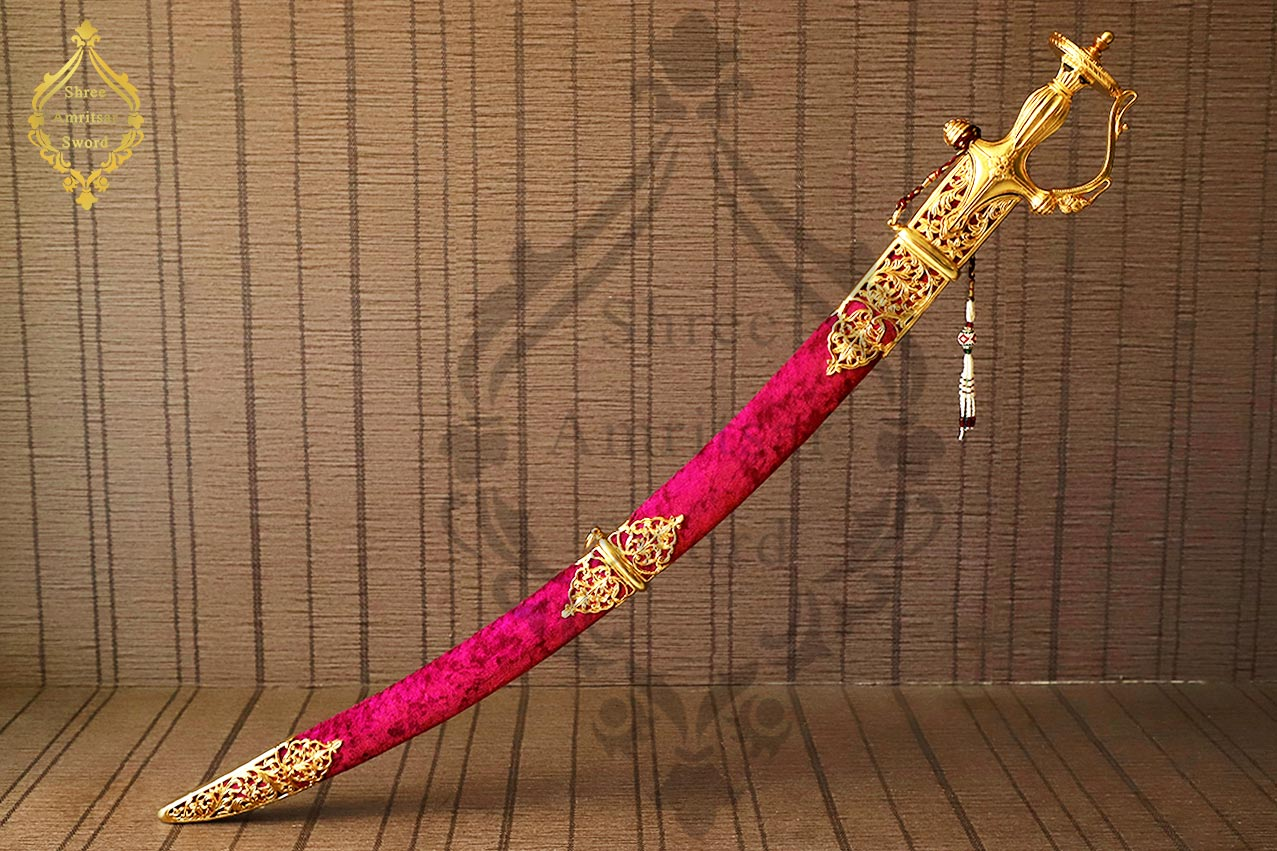

Weapon Type: Sword


In [82]:
sample_number = 110 # Which training sample
cv2_imshow(val_imgs[sample_number])
print("Weapon Type: " + num_to_class[np.argmax(predictions[sample_number])])